In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [2]:
file_path = "cleaned_coin_Bitcoin.csv"
data = pd.read_csv(file_path)


In [3]:
data.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap',
       'Daily Return', '50-Day MA', '200-Day MA', 'Price Diff', 'Volatility',
       'Open-Close Diff', 'High-Low Range'],
      dtype='object')

In [4]:
from sklearn.preprocessing import MinMaxScaler
# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Add a new feature: 'Timestamp' (number of seconds since epoch)
data['Timestamp'] = data['Date'].view('int64') // 10**9  # Convert to seconds

# Define target and features (include the 'Timestamp')
target = "Close"
X = data.drop(columns=["Date", target])  # Keep 'Timestamp' as a feature
y = data[target]

# Normalize the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)  # Scale features
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Scale target

# Verify the shapes and a quick preview
print(f"Features shape: {X_scaled.shape}, Target shape: {y_scaled.shape}")
print(f"Sample features (first row): {X_scaled[0]}")


Features shape: (1558, 13), Target shape: (1558, 1)
Sample features (first row): [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03328431e-04
 0.00000000e+00 6.08526083e-01 0.00000000e+00 0.00000000e+00
 1.57535573e-03 3.78986505e-01 0.00000000e+00 1.57535573e-03
 0.00000000e+00]


C:\Users\Aleix\AppData\Local\Temp\ipykernel_5232\456314390.py:6: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  data['Timestamp'] = data['Date'].view('int64') // 10**9  # Convert to seconds


In [5]:
data.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap',
       'Daily Return', '50-Day MA', '200-Day MA', 'Price Diff', 'Volatility',
       'Open-Close Diff', 'High-Low Range', 'Timestamp'],
      dtype='object')

In [6]:
train_size = 0.7
test_size = 0.2
val_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, train_size=train_size, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(test_size+val_size), shuffle=False)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Validation set size: {X_val.shape}")


Training set size: (1090, 13)
Testing set size: (312, 13)
Validation set size: (156, 13)


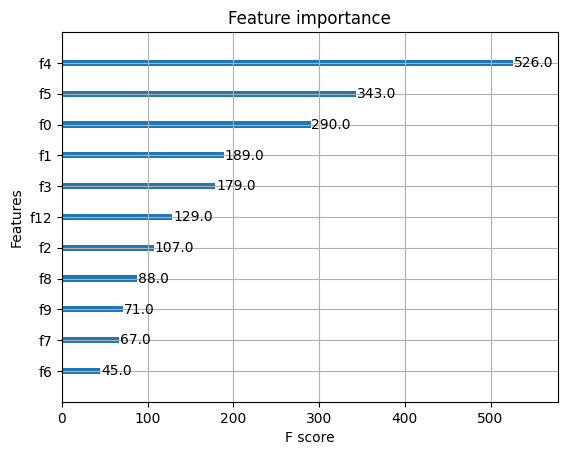

In [7]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Feature importance
xgb.plot_importance(xgb_model)
plt.show()

# Get XGBoost predictions
xgb_train_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)

# Use the predictions as a new feature for LSTM
X_train_lstm = np.hstack((X_train, xgb_train_preds.reshape(-1, 1)))
X_test_lstm = np.hstack((X_test, xgb_test_preds.reshape(-1, 1)))
X_val_lstm = np.hstack((X_val, xgb_model.predict(X_val).reshape(-1, 1)))


In [8]:
timesteps = 10  # Number of previous days to consider
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_lstm, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_lstm, y_test, timesteps)
X_val_seq, y_val_seq = create_sequences(X_val_lstm, y_val, timesteps)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Testing sequences shape: {X_test_seq.shape}")


Training sequences shape: (1080, 10, 14)
Testing sequences shape: (302, 10, 14)


In [9]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - loss: 0.0033 - mae: 0.0413 - val_loss: 0.0902 - val_mae: 0.2825
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 5.7733e-04 - mae: 0.0179 - val_loss: 0.0764 - val_mae: 0.2613
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 4.6309e-04 - mae: 0.0160 - val_loss: 0.0757 - val_mae: 0.2608
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.5606e-04 - mae: 0.0160 - val_loss: 0.0911 - val_mae: 0.2873
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.2316e-04 - mae: 0.0147 - val_loss: 0.0934 - val_mae: 0.2908
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.7040e-04 - mae: 0.0136 - val_loss: 0.0883 - val_mae: 0.2821
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.6940e-04 - mae: 0.0141 - val_loss: 0.0989 - val_mae: 0.2999
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.0452e-04 - mae: 0.0138 - val_loss: 0.1075 - val_mae: 0.3131
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7211e-04 - mae: 0.0083
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.8945e-04 - mae: 0.0145
Train Loss (MSE): 0.000161896095960401
Test Loss (MSE): 0.003020269563421607
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


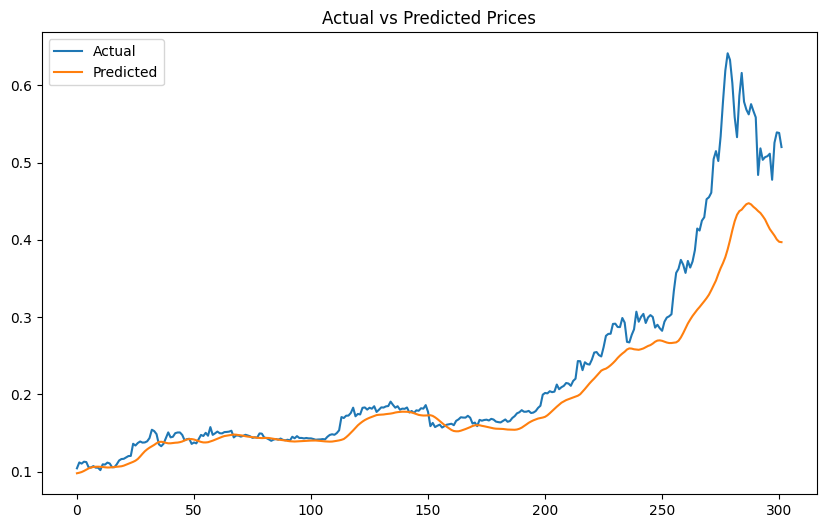

In [10]:
train_loss = lstm_model.evaluate(X_train_seq, y_train_seq)
test_loss = lstm_model.evaluate(X_test_seq, y_test_seq)

print(f"Train Loss (MSE): {train_loss[0]}")
print(f"Test Loss (MSE): {test_loss[0]}")

# Predictions
y_pred = lstm_model.predict(X_test_seq)

# Inverse transform predictions for readability
y_test_original = scaler_y.inverse_transform(y_test_seq)
y_pred_original = scaler_y.inverse_transform(y_pred)

# Plot true vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual")
plt.plot(y_pred_original, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# Print metrics
print("Model Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Model Metrics:
Mean Squared Error (MSE): 0.0029
Mean Absolute Error (MAE): 0.0301
Root Mean Squared Error (RMSE): 0.0542
R² Score: 0.8221


In [12]:
# Save the model
lstm_model.save("XGB&LSTM_hybride_close_predict.keras")
